# Прогнозирование температуры стали  

Описание проекта:

Металлургический комбинат «Стальная птица» стремится оптимизировать производственные расходы, снизив потребление электроэнергии при обработке стали. Для этого необходимо контролировать температуру сплава. В рамках проекта требуется разработать модель для предсказания этой температуры. Модель будет использоваться для имитации технологического процесса.


Данные состоят из нескольких файлов:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).


**Целевой признак: последняя измеренная температура в партии
Метрика: МАЕ, Качество  не более 6.8.**

##  Загрузка данных

In [1]:
!pip install --upgrade -q scikit-learn==1.4.1.post1

!pip install -q lightgbm
!pip install -q optuna
!pip install -q optuna-integration
!pip install -q numpy==1.22

!pip install -q shap

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 1.22.0 which is incompatible.


In [2]:
# импортируем необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# from mlxtend.plotting import plot_decision_regions

import scipy.stats as st
import numpy as np
import scipy as sp
import math

import requests
import joblib
import time

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import  LogisticRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import(
                             roc_auc_score,
                             f1_score,
                             recall_score,
                             precision_score,
                             accuracy_score,
                             confusion_matrix,
                             mean_absolute_error
)


from sklearn.preprocessing import(
                                   StandardScaler,
                                   MinMaxScaler,
                                   OneHotEncoder,
                                   LabelEncoder,
                                   OrdinalEncoder              
)

from sklearn.impute import SimpleImputer


# Блок  импортов и настроек Optuna
import optuna
from optuna.integration import OptunaSearchCV 
from optuna import distributions
import logging
import warnings

optuna.logging.set_verbosity(optuna.logging.WARNING) # отключить вывод optunaSearchCV 
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning) # предупреждения optuna.exceptions off.


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import shap

RANDOM_STATE = 220724

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
try:
    df_arc =pd.read_csv('data_arc_new.csv',parse_dates=['Начало нагрева дугой','Конец нагрева дугой'])
    df_temp = pd.read_csv('data_temp_new.csv', parse_dates=['Время замера'])

    df_bulk = pd.read_csv('data_bulk_new.csv')
    df_bulk_time = pd.read_csv('data_bulk_time_new.csv')

    df_wire = pd.read_csv('data_wire_new.csv')
    df_wire_time = pd.read_csv('data_wire_time_new.csv')

    df_gas = pd.read_csv('data_gas_new.csv')
except:
    df_arc =pd.read_csv('/datasets/data_arc_new.csv',parse_dates=['Начало нагрева дугой','Конец нагрева дугой'])
    df_temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=['Время замера'])

    df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

    df_wire = pd.read_csv('/datasets/data_wire_new.csv')
    df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

    df_gas = pd.read_csv('/datasets/data_gas_new.csv')    

Ознакомимся и проанализируем загруженные данные:
- df_arc- данные об электродах;
- df_temp - результаты измерения температуры;
- df_bulk, df_balk_time - данные  о сыпучих материалах объем и время;
- df_wire, df_wire_time - данные  о проволочных материалах объем и время;
- df_gas - данные о продувке газом.

Слова в названиях столбцов  приведем к нижнему регистру, пробелы заменим на нижнее подчеркивание, а также удалим  пробелы в начале и в конце названий. Для этого воспользуемся  функцией `transform_column_names `

In [4]:
def transform_column_names (df):
    list_name =  df.columns
    list_name= list_name.str.lower()
# заменяем пробелы и запятые на символ подчеркиваеия
    list_name = list_name.str.replace(' ','_').str.rstrip().str.lstrip()
    return list_name

_________________
**df_arc**

In [5]:
df_arc.head(10)

key Начало нагрева дугой Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14 2019-05-03 11:36:31           0.381124   
6    2  2019-05-03 11:38:50 2019-05-03 11:44:28           0.261665   
7    2  2019-05-03 11:46:19 2019-05-03 11:48:25           0.710297   
8    2  2019-05-03 11:49:48 2019-05-03 11:53:18           0.786322   
9    3  2019-05-03 12:06:54 2019-05-03 12:11:34           1.101678   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
5             0.220351  
6             0.205527  
7             0.484962  
8             0.542517  
9             0.820856

In [6]:
df_arc.columns = transform_column_names(df_arc)
df_arc.columns

Index(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой',
       'активная_мощность', 'реактивная_мощность'],
      dtype='object')

In [7]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Датафрейм включает 14876  строк, без пропущенных значений, типы данных соответствуют ожиданиям.

_____________
**df_temp**

In [8]:
df_temp.head(10)

key        Время замера  Температура
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0
5    1 2019-05-03 11:30:38       1613.0
6    2 2019-05-03 11:34:04       1581.0
7    2 2019-05-03 11:38:40       1577.0
8    2 2019-05-03 11:46:09       1589.0
9    2 2019-05-03 11:49:38       1604.0

In [9]:
df_temp.columns = transform_column_names(df_temp)
df_temp.columns

Index(['key', 'время_замера', 'температура'], dtype='object')

In [10]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Датафрейм включает 18092 строки, есть  пропущенные значения в столбце `температура`, типы данных соответствуют ожиданиям.

___________________________
**df_bulk**,   **df_bulk_time**

In [11]:
df_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

In [12]:
df_bulk.columns = transform_column_names(df_bulk)
df_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [13]:
df_bulk['bulk_1'].dtype

dtype('float64')

In [14]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Датафрейм включает 3129 строки, есть пропущенные значения, типы данных соответствуют ожиданиям.

In [15]:
df_bulk_time.head(10)

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   
5    6    NaN    NaN    NaN  2019-05-03 13:57:27    NaN    NaN    NaN    NaN   
6    7    NaN    NaN    NaN  2019-05-03 14:18:58    NaN    NaN    NaN    NaN   
7    8    NaN    NaN    NaN  2019-05-03 15:17:58    NaN    NaN    NaN    NaN   
8    9    NaN    NaN    NaN  2019-05-03 16:03:08    NaN    NaN    NaN    NaN   
9   10    NaN    NaN    NaN                  NaN    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   
5    NaN     NaN     NaN  2019-05-03 13:48:52     NaN  2019-05-03 14:09:42   
6    NaN     NaN     NaN  2019-05-03 14:41:26     NaN  2019-05-03 14:30:50   
7    NaN     NaN     NaN  2019-05-03 15:17:58     NaN  2019-05-03 15:13:18   
8    NaN     NaN     NaN  2019-05-03 16:03:08     NaN  2019-05-03 16:00:16   
9    NaN     NaN     NaN  2019-05-03 16:38:11     NaN  2019-05-03 16:34:24   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47  
5  2019-05-03 14:03:15  
6  2019-05-03 14:27:16  
7  2019-05-03 15:05:33  
8  2019-05-03 15:52:39  
9  2019-05-03 16:29:56

In [16]:
df_bulk_time.columns = transform_column_names(df_bulk_time)
df_bulk_time.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [17]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Датафрейм включает 3129 строки, есть пропущенные значения, типы данных требуют  преобразования в
*datetime*.

________________
**df_wire, df_wire_time**

In [18]:
df_wire.head()

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [19]:
df_wire.columns = transform_column_names(df_wire)
df_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [20]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Датафрейм включает 3081 строки, есть пропущенные значения, типы данных соответствуют ожиданиям.

In [21]:
df_wire_time.head(10)

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   
5    6  2019-05-03 13:57:27  2019-05-03 13:48:52    NaN    NaN    NaN    NaN   
6    7  2019-05-03 14:18:58                  NaN    NaN    NaN    NaN    NaN   
7    8  2019-05-03 15:01:30                  NaN    NaN    NaN    NaN    NaN   
8    9  2019-05-03 15:45:44  2019-05-03 15:39:37    NaN    NaN    NaN    NaN   
9   10  2019-05-03 16:27:00  2019-05-03 16:22:36    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
5    NaN    NaN    NaN  
6    NaN    NaN    NaN  
7    NaN    NaN    NaN  
8    NaN    NaN    NaN  
9    NaN    NaN    NaN

In [22]:
df_wire_time.columns = transform_column_names(df_wire_time)
df_wire_time.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [23]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Датафрейм включает 3081 строку, есть пропущенные значения, типы данных требуют преобразования в datetime.

____________________________________
df_gas

In [24]:
df_gas.head()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [25]:
df_gas.columns = transform_column_names(df_gas)
df_gas.columns

Index(['key', 'газ_1'], dtype='object')

In [26]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Датафрейм включает 3239 строк, без пропущенных значений, типы данных соответствуют ожиданиям.

## Предобработка и предварительный анализ данных.

Процесс выплавки стали в ковше носит периодический характер и осуществляется партиями. Каждая партия согласно технологической карте может иметь несколько последовательных шагов- итераций:

разогрев стали до нужной температуры;
внесение сыпучих реагентов и легирующей проволоки; Весь процесс сопровождается продувкой инертным газом для создания однородности стали. В конце каждого шага производится замер температуры и химический анализ стали. По результатам измерений производится коррекция температуры и расчитываются объемы реагентов. Перед началом обработки стали также выполняется замер температуры и химчиский анализ стали для получения исходных данных для первой итерации партии.

Как уже отмечалось ранее целевым признаком является температура, измеренная  по окончанию последней итерации  в партии.<br>
Значения температуры, полученные на  предыдущих этапах  могут быть использованы  в качестве входных признаков  для обучения модели.
**Данные с целевым признаком содержатся в датафрейме  `df_temp` поэтому предобработку начнем с него.**



Определим условия, при котрых  для каждой партии будет определен целевой признак:
- целевой  признак не дожен быть пропущен
- количество наблюдений  внутри партии должно быть не менее двух.

Для удобства навигации по датафрейму  пронумеруем итерациии  внутри каждой партии начиная с 0 значения для первого измерения температуры.
Отфильтруем датафрейм по этим условиям.
  





#### df_temp

In [27]:
df_temp['num'] = df_temp.groupby(by='key').cumcount()
df_temp.head(10)

key        время_замера  температура  num
0    1 2019-05-03 11:02:04       1571.0    0
1    1 2019-05-03 11:07:18       1604.0    1
2    1 2019-05-03 11:11:34       1618.0    2
3    1 2019-05-03 11:18:04       1601.0    3
4    1 2019-05-03 11:25:59       1606.0    4
5    1 2019-05-03 11:30:38       1613.0    5
6    2 2019-05-03 11:34:04       1581.0    0
7    2 2019-05-03 11:38:40       1577.0    1
8    2 2019-05-03 11:46:09       1589.0    2
9    2 2019-05-03 11:49:38       1604.0    3

In [28]:
df_temp.isna().sum()

key                0
время_замера       0
температура     3427
num                0
dtype: int64

В датафрейме содержится 3427 пропущенных значений в целевом признаке. Определим серии, в которых есть пропуски. Затем проанализируем эти серии, чтобы понять, на каких итерациях присутствуют пропуски, а на каких их нет. Это поможет принять решение о необходимости исключения партий стали, в которых не определен целевой признак.

Почему мы не удаляем партии с пропусками сразу? Возможно, пропуск произошел на этапе промежуточной итерации, и целевой признак в партии сохранился.

Список **key_miss** содержит ключи серий с пропусками.

In [29]:

key_miss = df_temp[df_temp['температура'].isna()]['key'].unique()
# Определим  номер  итераций 
print(f"Номера итераций без пропусков: {df_temp.query(' key.isin(@key_miss) and ~температура.isna()')['num'].unique()}")

Номера итераций без пропусков: [0]


Наше изначальное предположение не подтвердилось, в сериях значения без пропусков  сооответствуют первому измерению  температуры, значения  целевого признака  прпущены  во всех сериях. Напомним, что эти ключи хранятся в массиве **key_miss**.

Проверим  второе условие: наличие минимум двух итераций в сериях. Создадим  массив **key_one** для ключей  таких серий.

In [30]:
key_one= df_temp['key'].value_counts()[df_temp['key'].value_counts()<2].index
key_one

Int64Index([279, 195], dtype='int64')


Добавим значения массива **key_one** к массиву **key_miss** и
удалим строки по значению  столбца `key` из списка **key_miss**.  
Проверим результат.

В дальнейшей  предобработке  будем удалять наблюдения из других датафреймов со значением ключа из  массива **key_miss**

In [31]:
key_miss=a = np.hstack((key_one,key_miss))

df_temp.drop(df_temp.query('key.isin(@key_miss)').index, inplace=True)
print(df_temp.isna().sum(),'\n'*3, df_temp.query('key.isin(@key_miss)'),'\n')
print('Количество итераций  в сериях:','\n',df_temp['key'].value_counts().tail(1),'\n')
df_temp.info()

key             0
время_замера    0
температура     0
num             0
dtype: int64 


 Empty DataFrame
Columns: [key, время_замера, температура, num]
Index: [] 

Количество итераций  в сериях: 
 1281    2
Name: key, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13924 entries, 0 to 13925
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13924 non-null  int64         
 1   время_замера  13924 non-null  datetime64[ns]
 2   температура   13924 non-null  float64       
 3   num           13924 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 543.9 KB


Проанализируем результат:
- пропусков  в данных нет;
- в  датафрейме удалены серии   в котырых был пропущен целевойй признак;
- минимальное количество итерций в сериях равно двум.

In [32]:
df_temp

key        время_замера  температура  num
0         1 2019-05-03 11:02:04       1571.0    0
1         1 2019-05-03 11:07:18       1604.0    1
2         1 2019-05-03 11:11:34       1618.0    2
3         1 2019-05-03 11:18:04       1601.0    3
4         1 2019-05-03 11:25:59       1606.0    4
...     ...                 ...          ...  ...
13921  2499 2019-08-10 13:33:21       1569.0    0
13922  2499 2019-08-10 13:41:34       1604.0    1
13923  2499 2019-08-10 13:46:28       1593.0    2
13924  2499 2019-08-10 13:54:56       1588.0    3
13925  2499 2019-08-10 13:58:58       1603.0    4

[13924 rows x 4 columns]

Преобразуем  датафрейм таким образом  чтобы одна серия  соответствовала одному наблюдению ( 1 строка)

In [33]:
df_new_temp = df_temp.groupby('key').agg({'температура':['first','last'],
                                          'время_замера':(lambda x: (x.max() - x.min()).total_seconds()),
                                          'num':'max'})

In [34]:
df_new_temp.reset_index(drop=False, inplace=True)


In [35]:
df_new_temp.columns

MultiIndex([(         'key',         ''),
            ( 'температура',    'first'),
            ( 'температура',     'last'),
            ('время_замера', '<lambda>'),
            (         'num',      'max')],
           )

In [36]:
df_new_temp.columns=['key','temperature_in','temperature_out', 'casting_time', 'num_itter']

In [37]:
# Присвоение новых имен столбцам
df_new_temp.columns = ['key', 'temperature_in', 'temperature_out', 'casting_time', 'num_itter']
df_new_temp['time_iter'] =round(df_new_temp['casting_time']/df_new_temp['num_itter'],2)

In [38]:
df_new_temp.head()

key  temperature_in  temperature_out  casting_time  num_itter  time_iter
0    1          1571.0           1613.0        1714.0          5     342.80
1    2          1581.0           1602.0        1265.0          4     316.25
2    3          1596.0           1599.0        1753.0          5     350.60
3    4          1601.0           1625.0        1220.0          4     305.00
4    5          1576.0           1602.0        1536.0          4     384.00

В результате мы получили датафрейм `df_new_temp`со столбцами:
- key -номер партии;
- temperature_in  -  входная температура;
- temperature_out  - целевой признак, температура на выходе;
- casting_time  - время выплавки;
- num_itter - количество итераций;
- time_iter - среднее время итерации.

Проведем статистический анализ признаков `df_new_temp`

In [39]:
df_new_temp.describe()

key  temperature_in  temperature_out  casting_time  \
count  2475.000000     2475.000000      2475.000000   2475.000000   
mean   1250.787071     1588.402020      1595.336162   2280.896566   
std     719.787271       29.243044        16.023153   1373.705572   
min       1.000000     1191.000000      1541.000000    339.000000   
25%     629.500000     1572.000000      1587.000000   1544.500000   
50%    1252.000000     1588.000000      1593.000000   2009.000000   
75%    1872.500000     1605.000000      1599.000000   2738.500000   
max    2499.000000     1679.000000      1700.000000  23674.000000   

         num_itter    time_iter  
count  2475.000000  2475.000000  
mean      4.625859   522.955046  
std       1.610087   420.675795  
min       1.000000   169.500000  
25%       4.000000   364.270000  
50%       4.000000   445.000000  
75%       6.000000   562.485000  
max      16.000000  8390.000000

Для  построения гиттограммы  и боксплот  воспользуемся функцией **gist_box**.

In [40]:
# data масиив значений для построения,
# gist_titl, box_titl - названия графиков,
# gist_x, gist_y -названия осей гистограммы,
# gist_x,gist_y - названия осей для боксплота,
#total_titl - общее название фигуры,
# bin- количество ведер в гистограмме

def gist_box (data, gist_titl='Gist', gist_x ='x',gist_y='частота',
                     box_titl='Box', box_x = 'x',   box_y='у',  total_titl='total',bin=10):
    gist_titl='Гистограмма'
    box_titl='Ящик с усами'
    box_x =''
    box_y =  gist_x
    total_titl=' Частота распределения и ящик с усами для столбца   '+ total_titl 
# Создание гистограммы.
    # fig_hist = go.Figure(go.Histogram(x=data, xbins=dict(size=bin)))
    fig_hist = px.histogram(x=data, nbins=bin)

    # Создание боксплота.
    # fig_box = go.Figure(go.Box(y=data))
    fig_box = px.box(y=data)
# Создание фигуры и размещение на ней графиков.
    fig = make_subplots(rows=1, cols=2,subplot_titles=(gist_titl, box_titl) )

    fig.add_trace(fig_hist.data[0], row=1, col=1)
    fig.add_trace(fig_box.data[0], row=1, col=2)

# Установка общего заголовка для фигуры, названия осей.
    fig.update_layout(title=total_titl,title_font_size=20, width=1000, height=500)
    fig.update_xaxes(title_text=gist_x, row=1, col=1)
    fig.update_xaxes(title_text=box_x, row=1, col=2)
    fig.update_yaxes(title_text=gist_y, row=1, col=1)
    fig.update_yaxes(title_text=box_y, row=1, col=2)
    
# Отображение фигуры
    fig.show()

In [41]:
# Функция для построения матрицы корреляции Пирсона
# data - датафрейм  спризнаками
# title - название  датафрема

def corr_make (data, title, width=12, height=7):
    corr_data = data.corr().round(2)
    plt.figure(figsize=(width, height))
    sns.heatmap(corr_data, annot=True, fmt='.2f',cmap='inferno')
    plt.title(f'матрица корреляции Пирсона для признаков {title}')
    plt.show()
# cividis, plasma, inferno, magma, jet, bone

In [42]:
#  Функция для построения графиков  боксплот,  выбранных признаков  датафрейма.
# data - датафрейм  спризнаками.
# title - название  датафрема.

def boxplots_make(data, title, value = ' '):
    df_long = pd.melt(data, var_name='Variable', value_name='Value')

    # Создание боксплота
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='Variable', y='Value', data=df_long)
    
    plt.title('Боксплот для столбцов '+title)
    plt.xlabel('')
    plt.ylabel(value)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [43]:
BIN=50
gist_box(data=df_new_temp['temperature_in'],
         gist_x='температура,C ᵒ.',
         total_titl="temperature_in .",bin=BIN)
         


- Диапазон значений `temperature_in` варьируется oт 1191 до 1679 Сͦ. 
-      
- Медиана и среднее равны соответственно 1588 Сͦ.
- Стандартное отклонение составляет 29 Сͦ.
- На боксплоте можно наблюдать единичные выбросы вниз, причем  четыре  из них находятся  существенно ниже границы 1525 Сͦ.
- Распределение визуально приближено к нормальному.

Температура плавления стали лежит в диапазоне от 1370 до 1530 Сᵒ,  в зависимости от марки, значения ниже этого диапазона являются  аномальными,  уберем  такие наблюдения  из выборки,  также добавим  номера этих серий  в массив **key_miss**.



In [44]:
key_anomaly_temp = df_new_temp.query('temperature_in<1370')['key'].to_numpy()
key_miss=np.hstack((key_miss, key_anomaly_temp))
df_new_temp.drop(df_new_temp.query('key.isin(@key_anomaly_temp)').index, inplace=True)


In [45]:
df_new_temp.query('key.isin(@key_anomaly_temp)')

Empty DataFrame
Columns: [key, temperature_in, temperature_out, casting_time, num_itter, time_iter]
Index: []

Серии  с аномалиями удалены из датафрейма.

In [46]:
BIN=30
gist_box(data=df_new_temp['temperature_out'],
         gist_x='температура,C ᵒ.',
         total_titl="temperature_out .",bin=BIN)
         


- Диапазон значений `temperature_out`(целевой признак) варьируется oт 1541 до 1700 Сͦ. 
-      
- Медиана и среднее равны соответственно 1593 и 1595 Сͦ.
- Стандартное отклонение составляет 16 Сͦ.
- На боксплоте можно наблюдать выбросы вниз от 1569 Сᵒ и вверх от 1617 Сͦ.

Такие  выбросы будем считать статистическими  и не требующие корректировки.



In [47]:
BIN=30
gist_box(data=df_new_temp['casting_time'],
         gist_x='время, с.',
         total_titl="casting_time",bin=BIN)
         


- Диапазон значений `casting_time` варьируется oт 339 до 23674 сек. 
-      
- Медиана и среднее равны соответственно   2738 и 2280 сек.
- Стандартное отклонение составляет 1374 сек.
- На боксплоте можно наблюдать выбросы  вверх от 4506 сек.

Такие  выбросы будем считать статистическими  и не требующие корректировки.



In [48]:
BIN=30
gist_box(data=df_new_temp['time_iter'],
         gist_x='время, с.',
         total_titl="time_iter ",bin=BIN)
         


- Диапазон значений `time_iter` варьируется oт 169 до 8390 сек. 
-      
- Медиана и среднее равны соответственно   445 и 522 сек.
- Стандартное отклонение составляет 420 сек.
- На боксплоте можно наблюдать выбросы  вверх от 860 сек.

Такие  выбросы будем считать статистическими  и не требующие корректировки.



In [49]:
print('Размер df_new_temp :',df_new_temp.shape)

Размер df_new_temp : (2471, 6)



#### df_arc

Пронумеруем итерации  в сериях и создадим  столбец `time_iter` - время итерации  в секундах.

In [50]:
df_arc['num'] = df_arc.groupby(by='key').cumcount() + 1

In [51]:
df_arc['time_iter']=(df_arc['конец_нагрева_дугой'] - df_arc['начало_нагрева_дугой']).dt.total_seconds()

In [52]:
df_arc.head(15)

key начало_нагрева_дугой конец_нагрева_дугой  активная_мощность  \
0     1  2019-05-03 11:02:14 2019-05-03 11:06:02           0.305130   
1     1  2019-05-03 11:07:28 2019-05-03 11:10:33           0.765658   
2     1  2019-05-03 11:11:44 2019-05-03 11:14:36           0.580313   
3     1  2019-05-03 11:18:14 2019-05-03 11:24:19           0.518496   
4     1  2019-05-03 11:26:09 2019-05-03 11:28:37           0.867133   
5     2  2019-05-03 11:34:14 2019-05-03 11:36:31           0.381124   
6     2  2019-05-03 11:38:50 2019-05-03 11:44:28           0.261665   
7     2  2019-05-03 11:46:19 2019-05-03 11:48:25           0.710297   
8     2  2019-05-03 11:49:48 2019-05-03 11:53:18           0.786322   
9     3  2019-05-03 12:06:54 2019-05-03 12:11:34           1.101678   
10    3  2019-05-03 12:13:52 2019-05-03 12:15:56           0.542675   
11    3  2019-05-03 12:18:56 2019-05-03 12:20:45           0.774632   
12    3  2019-05-03 12:25:43 2019-05-03 12:27:00           1.222963   
13    3  2019-05-03 12:31:14 2019-05-03 12:32:19           0.421693   
14    4  2019-05-03 12:39:37 2019-05-03 12:43:04           0.642946   

    реактивная_мощность  num  time_iter  
0              0.211253    1      228.0  
1              0.477438    2      185.0  
2              0.430460    3      172.0  
3              0.379979    4      365.0  
4              0.643691    5      148.0  
5              0.220351    1      137.0  
6              0.205527    2      338.0  
7              0.484962    3      126.0  
8              0.542517    4      210.0  
9              0.820856    1      280.0  
10             0.474673    2      124.0  
11             0.505690    3      109.0  
12             0.863676    4       77.0  
13             0.272562    5       65.0  
14             0.516071    1      207.0

Удалим из `df_arc` серии с ключами из массива **key_miss**  
Напомним, что в массиве key_miss находятся ключи партий, для которых не определён целевой признак. Обработка пропущенных значений и изменение типов данных  в этом датафрейме не требуется. 

In [53]:
df_arc.drop(df_arc.query('key.isin(@key_miss)').index, inplace=True)

При нагревании в печи с использованием графитовых электродов  активная мощность (активная составляющая электрической энергии) является основным фактором, определяющим количество тепла, передаваемого нагреваемому объекту. 
Реактивная мощность, связана с индуктивными или емкостными компонентами цепи и не участвует напрямую в нагреве. Она может быть связана с потерями энергии, такими как нагрев кабелей и оборудования, но не вносит вклад в нагрев самого объекта.

Следовательно, для расчёта энергии, передаваемой объекту, и, следовательно, для предсказания его температуры после нагрева, нужно учитывать только активную мощность  и время работы нагревателя.

Следуя этому  сгруппируем датафрем **df_arc** следующим образом:
для каждой партии расчитаем суммарную энергию,  перданную посредством нагрева, используя следующую формулу:

$\sum_{i=1}^{20} P_i \cdot t_i$
- P - активная  мощность на итерации ii;
- t - интервал  времени в сек. на i  итерации;
- n - число итераций.

In [54]:
df_new_arc = df_arc.groupby('key')\
.apply(lambda x:round((x['активная_мощность']*x['time_iter']).sum())).to_frame().reset_index()
df_new_arc.columns=['key','energy_total']

In [55]:
df_new_arc

key  energy_total
0        1           629
1        2           395
2        3           582
3        4           544
4        5           412
...    ...           ...
2466  2495           572
2467  2496           675
2468  2497           680
2469  2498           475
2470  2499           428

[2471 rows x 2 columns]

Проведем статистический анализ признака 'energy_total'  

In [56]:
df_new_arc.describe()

key  energy_total
count  2471.000000   2471.000000
mean   1250.484015    533.957912
std     720.109488    256.635875
min       1.000000     26.000000
25%     628.500000    362.000000
50%    1252.000000    503.000000
75%    1872.500000    676.500000
max    2499.000000   3718.000000

In [57]:
BIN=100
gist_box(data=df_new_arc['energy_total'],
         gist_x='Дж',
         total_titl="energy_total ",bin=BIN)
         

In [58]:
print('Количество выбросов:',df_new_arc.query('energy_total>1189').sort_values(by= 'energy_total')['key'].count())

Количество выбросов: 33



- Диапазон значений `energy_total` варьируется oт 26 до 3718.
-      
- Медиана и среднее равны соответственно 503 и 533.
- Стандартное отклонение составляет 256.
- На боксплоте можно наблюдать  выбросы вверх , причем  один  из них находятся  существенно выше границы 1143, на уровне 3718

Такие выбросы будем считать статистическими и не требующие корректировки.


In [59]:
print('Размер df_new_arc :',df_new_arc.shape)

Размер df_new_arc : (2471, 2)



#### df_bulk

В DataFrame `df_bulk` содержатся данные о 15 различных наименованиях сыпучих материалов.
Для каждой партии используется свой набор реагентов, и если какой-либо материал не использовался, то в таблице появляется пропуск.
Так как количество пропусков в признаках существенно, целесообразнее построить описательные статистики и графики боксплот на имеющихся данных, не заполняя пропуски нулями. Это позволит избежать искажения распределения данных,особенно если нули указывают на отсутствие использования материалов в определённых партиях.

Мы будем следовать следующим шагам для анализа:
- Удалим наблюдения  по ключу  из массива **key_miss**
- Создадим  агрегированный признак  из  суммы компонентов -'bulk_sum'
- расчитаем описательные статистики  и графики  боксплот
- построим гистограмму и боксплот для признака 'bulk_sum'
- Заполним пропуски нулями.
- пострим матрицу корреляции для признаков в df_bulck.


In [60]:
print('Наличие дубликатов в столбце key :',df_bulk['key'].duplicated().sum())

Наличие дубликатов в столбце key : 0


In [61]:

df_bulk.drop(df_bulk.query('key.isin(@key_miss)').index, inplace=True)
df_bulk['bulk_sum']=df_bulk.sum(axis=1)

In [62]:
df_bulk.drop('key',axis=1).describe()

bulk_1      bulk_2      bulk_3      bulk_4      bulk_5      bulk_6  \
count  199.000000   13.000000  963.000000  813.000000   53.000000  443.000000   
mean    40.115578  254.846154  114.798546  107.124231  116.018868  119.209932   
std     18.226180   25.973853   77.243634   49.104724   95.189182   70.537713   
min     10.000000  228.000000    6.000000   13.000000   11.000000   17.000000   
25%     27.000000  242.000000   57.500000   73.000000   70.000000   72.000000   
50%     33.000000  248.000000   97.000000  105.000000   88.000000  100.000000   
75%     46.500000  258.000000  152.000000  137.000000  148.000000  155.500000   
max    185.000000  325.000000  454.000000  281.000000  603.000000  503.000000   

           bulk_7  bulk_8      bulk_9     bulk_10     bulk_11      bulk_12  \
count   14.000000     1.0   13.000000  143.000000  130.000000  1879.000000   
mean   336.857143    49.0   79.692308   82.293706   76.053846   267.522618   
std    217.268305     NaN   25.795299   27.788900   60.373554   125.048278   
min     47.000000    49.0   63.000000   24.000000    8.000000    53.000000   
25%    160.750000    49.0   66.000000   58.000000   25.000000   204.000000   
50%    349.000000    49.0   68.000000   85.000000   60.000000   207.000000   
75%    481.750000    49.0   71.000000  104.000000  105.500000   360.000000   
max    772.000000    49.0  147.000000  159.000000  313.000000  1849.000000   

          bulk_13      bulk_14      bulk_15     bulk_sum  
count   14.000000  2134.000000  1710.000000  2403.000000  
mean   177.571429   173.341612   164.432164  1855.324594  
std     50.344527    64.714418    50.011032   765.264824  
min    151.000000    29.000000     1.000000    93.000000  
25%    153.250000   122.000000   105.000000  1242.000000  
50%    154.500000   153.000000   200.000000  1834.000000  
75%    158.500000   208.000000   205.000000  2479.000000  
max    305.000000   636.000000   405.000000  3613.000000

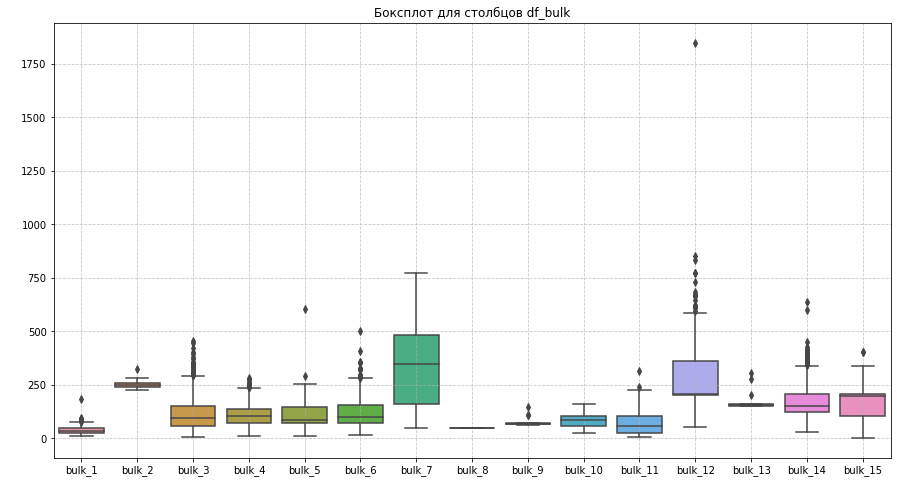

In [63]:
boxplots_make(df_bulk.drop(['key','bulk_sum'],axis=1), 'df_bulk') 

Детальный анализ признаков датафрейма `df_bulk` выходит  за рамки этого проекта, заказчик  предпочел не раскрывать информацию  о характере
и свойствах сыпучих реагентов. Исходя  из  анализа статистик  и графиков боксплот можно сделать следующие выводы:
- все  признаки  имеют статистические выбросы за исключением bulk_7.
- bulk_8 применялся единажды  в одной серии
- bulk_12 имеет существенный   выброс, превышающуй порог "верхнего уса"  примерно  в три раза
- наиболее   значимые признаки по количеству  применений  в сериях: bulk_14, bulk_12, bulk_15, bulk_3, bulk_4
- наименее  значимые:  bulk_8, bulk_2, bulk_7, bulk_9, bulk_5

Синтетический признак bulk_sum рассмотрим отдельно ниже.

In [64]:
BIN=50
gist_box(data=df_bulk['bulk_sum'], gist_titl='Гистограмма',box_titl='Ящик с усами',
         gist_x='лет',box_y='лет',box_x='',
         total_titl= "bulk_sum ",bin=BIN)
         

- Диапазон значений 'bulk_sum' варьируется oт 93 до 3613.
- Медиана и среднее близкие  по значению и равны соответственно 1834 и1855.
- Стандартное отклонение составляет 765
- На боксплоте выбросов нет
- Распределение визуально приближено к равномерному.

Заполним пропуски нулями  и построим  матрицу корреляции Пирсона.

In [65]:
df_bulk.fillna(0, inplace=True)

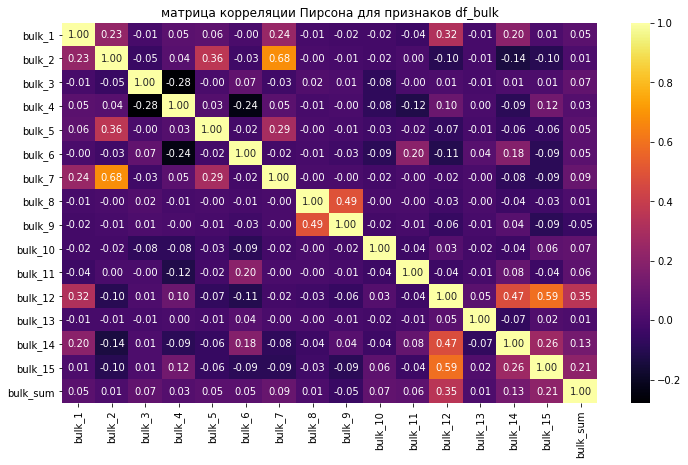

In [66]:

corr_make (df_bulk.drop('key',axis=1),'df_bulk')

Для оценки силы корреляции можно воспользоваться таблицей Шелдона:

| Корреляция  | Описание                      |
|------------ | ------------------------------|
| 0.00 - 0.10 | Очень слабая или отсутствует  |
| 0.10 - 0.30 | Слабая корреляция             |
| 0.30 - 0.50 | Умеренная корреляция          |
| 0.50 - 0.70 | Сильная корреляция            |
| 0.70 - 1.00 | Очень сильная корреляция      |

Выводы:
- Признаков  с мультикорреляцей  в данных `df_bulk` нет.
- Сильная положительная корреляция между значимыми признаками bulk_12, bulk_15 - 0.59
- Умеренная положительная  корреляция между значимыми признаками bulk_12, bulk_14 - 0.47
- Сильная положительная  корреляция между малозначимыми признаками bulk_2, bulk_7 - 0.68
- Признак bulk-sum  умеренно положительно коррелирует с bulk_12 и слабо  положительно коррелирует с bulk_15 

По итогам  разведочного анализа предлагаем включить все признаки  `df_bulk` в итоговый датафрейм для обчения и тестирования модели.


In [67]:
print('Размер df_bulk:',df_bulk.shape)

Размер df_bulk: (2403, 17)



#### df_wire

In [68]:
df_wire

key      wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  \
0        1   60.059998      NaN     NaN     NaN     NaN     NaN     NaN   
1        2   96.052315      NaN     NaN     NaN     NaN     NaN     NaN   
2        3   91.160157      NaN     NaN     NaN     NaN     NaN     NaN   
3        4   89.063515      NaN     NaN     NaN     NaN     NaN     NaN   
4        5   89.238236  9.11456     NaN     NaN     NaN     NaN     NaN   
...    ...         ...      ...     ...     ...     ...     ...     ...   
3076  3237   38.088959      NaN     NaN     NaN     NaN     NaN     NaN   
3077  3238   56.128799      NaN     NaN     NaN     NaN     NaN     NaN   
3078  3239  143.357761      NaN     NaN     NaN     NaN     NaN     NaN   
3079  3240   34.070400      NaN     NaN     NaN     NaN     NaN     NaN   
3080  3241   63.117595      NaN     NaN     NaN     NaN     NaN     NaN   

      wire_8  wire_9  
0        NaN     NaN  
1        NaN     NaN  
2        NaN     NaN  
3        NaN     NaN  
4        NaN     NaN  
...      ...     ...  
3076     NaN     NaN  
3077     NaN     NaN  
3078     NaN     NaN  
3079     NaN     NaN  
3080     NaN     NaN  

[3081 rows x 10 columns]

In [69]:
print('Наличие дубликатов в столбце key :',df_wire['key'].duplicated().sum())

Наличие дубликатов в столбце key : 0


В DataFrame `df_bulk` содержатся данные о 9 различных наименованиях проволочных материалов.
Для каждой партии используется свой набор  проволочных материалов, и если какой-либо материал не использовался, то в таблице появляется пропуск.
Так как количество пропусков в признаках существенно, целесообразнее построить описательные статистики и графики боксплот на имеющихся данных, не заполняя пропуски нулями. Это позволит избежать искажения распределения данных,особенно если нули указывают на отсутствие использования материалов в определённых партиях.

Мы будем выполнять аналогичные шаги для анализа, как в предыдущем разделе:
- Удалим наблюдения  по ключу  из массива **key_miss**
- Создадим  агрегированный признак  из  суммы компонентов -'wire_sum'
- расчитаем описательные статистики  и построим графики  боксплот
- построим гистограмму и боксплот для признака 'wire_sum'
- Заполним пропуски нулями.
- пострим матрицу корреляции для признаков в df_wire.


In [70]:
df_wire.drop(df_wire.query('key.isin(@key_miss)').index, inplace=True)
df_wire['wire_sum']=df_wire.sum(axis=1)

df_wire.drop('key', axis=1).describe().round(2)

wire_1  wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
count  2344.00  831.00   39.00   12.00     0.0   45.00    4.00   13.00   
mean    103.28   50.87  193.18   59.50     NaN   50.66    3.70   55.77   
std      42.61   40.09  100.87   30.80     NaN   37.74    3.82   20.24   
min       1.92    0.03    0.14   24.15     NaN    0.14    0.23   45.08   
25%      74.21   20.21   93.19   38.35     NaN   25.05    0.85   46.00   
50%     101.98   40.11  236.97   49.66     NaN   40.09    3.04   46.19   
75%     128.91   70.09  277.07   84.76     NaN   65.04    5.90   46.28   
max     330.31  282.78  385.01  113.23     NaN  180.45    8.49  102.76   

       wire_9  wire_sum  
count   28.00   2368.00  
mean    35.10   1376.46  
std     19.63    719.86  
min      4.62     61.06  
25%     23.18    752.15  
50%     30.08   1386.63  
75%     44.94   1995.70  
max     90.05   2814.28

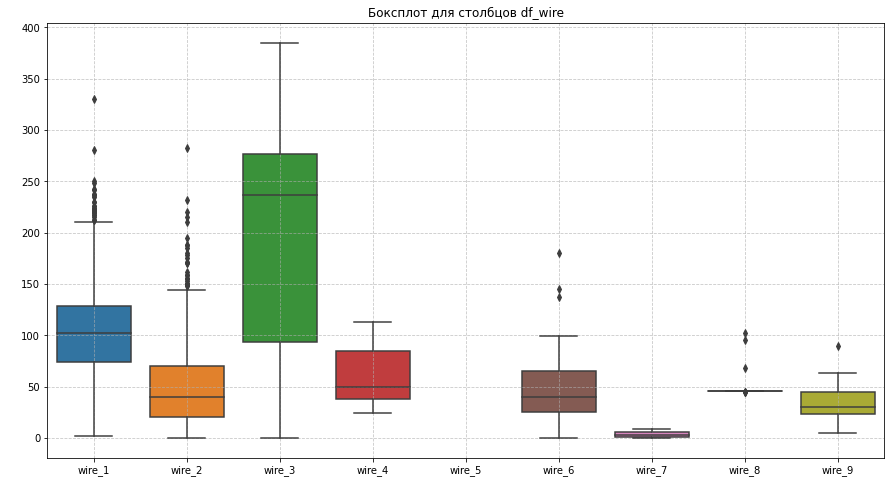

In [71]:
boxplots_make(df_wire.drop(['key','wire_sum'],axis=1), 'df_wire') 

Детальный анализ признаков датафрейма df_wire  выходит за рамки этого проекта, заказчик предпочел не раскрывать информацию о характере и свойствах проволочных добавок. Исходя из анализа статистик и графиков боксплот можно сделать следующие выводы:

- признаки имеют статистические выбросы: wire_1, wire_2, wire_6, wire_8, wire_9;
- **wire_5 не применялся ни в одной серии**;

- наиболее значимые признаки по количеству применений в сериях:wire_1, wire_2 ;
- остальные признаки малоиспользуемые ( количество наблюдений не превышает 50 для каждого прзнака);
Синтетический признак bulk_sum рассмотрим отдельно ниже.

Признак 'wire_5' удалим из наблюдений.

In [72]:
df_wire.drop('wire_5',axis=1,inplace=True )

In [73]:
BIN=30
gist_box(data=df_wire['wire_sum'], gist_titl='Гистограмма',box_titl='Ящик с усами',
         gist_x='лет',box_y='лет',box_x='',
         total_titl= "wire_sum ",bin=BIN)

- Диапазон значений wire_sum варьируется oт 61 до 2814.
- Медиана и среднее близкие  по значению и равны соответственно 1386 и1376.
- Стандартное отклонение составляет 720.
- На боксплоте выбросов нет.
- Распределение визуально приближено к равномерному.

Заполним пропуски нулями  и построим  матрицу корреляции.

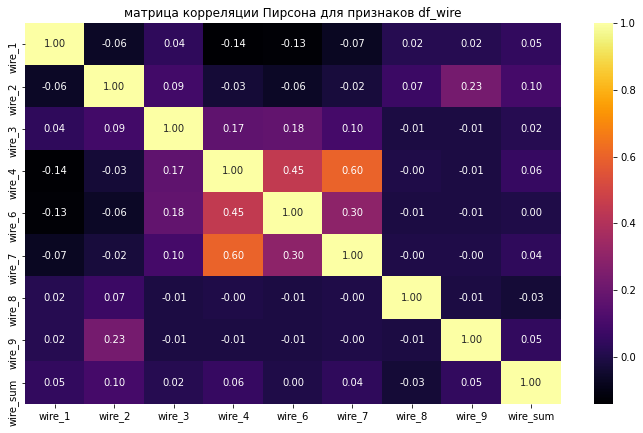

In [74]:
df_wire.fillna(0, inplace=True)

corr_make (df_wire.drop('key',axis=1),'df_wire')

Выводы:
- Признаков  с мультикорреляцей  в данных `df_wire` нет.
- Сильная положительная корреляция между значимыми признаками wire_4 и wire_7 - 0.60
- Умеренная положительная  корреляция между значимыми признаками  wire_4 и wire_6 -0.45
- Между остальными признаками очень слабаякорреляция 


In [75]:
print('Размер df_wire:',df_wire.shape)

Размер df_wire: (2368, 10)


**Признаки в  `df_bulk_time` и `df_wire_time` содержат временные  метки  и  в качестве признаков использоваться не будут.**

#### df_gas

In [76]:
df_gas.drop(df_gas.query('key.isin(@key_miss)').index, inplace=True)

In [77]:
print('Наличие дубликатов в столбце key :',df_gas['key'].duplicated().sum())

Наличие дубликатов в столбце key : 0


расчитаем описательные статистики, построим гистограмму и боксплот.

In [78]:
df_gas[['газ_1']].describe()

газ_1
count  2494.000000
mean     11.041755
std       6.379755
min       0.008399
25%       7.035514
50%       9.872859
75%      13.843829
max      77.995040

In [79]:
BIN=100
gist_box(data=df_gas['газ_1'], gist_titl='Гистограмма',box_titl='Ящик с усами',
         gist_x='лет',box_y='лет',box_x='',
         total_titl= "газ_1",bin=BIN)


- Диапазон значений `газ_1` варьируется oт 0 до 78.
-      
- Медиана и среднее равны соответственно 9.87 и 11.74.
- Стандартное отклонение составляет 6.38.
- На боксплоте можно наблюдать  выбросы вверх с уровня 24

Такие выбросы будем считать статистическими и не требующие корректировки.


In [80]:
print('Размер df_gas:',df_gas.shape)

Размер df_gas: (2494, 2)


В результате  выполнения предобработки и предварительного аналаза подготовлены для объединения датафреймы
- df_new_temp - содержит целевой признак , начальную температуру, временные характеристики серии. 
- df_arc - наблюдения о работе  нагревателей
-df_bulk -  признаки  с сыпучими реагентами
-df_wire -  признаки  с проволочными компонентами
- df_gas - сведения о продувке газом

Все датафреймы приведены к формату "одна строка — одно наблюдение" (набор признаков, характеризующих партию). В них обработаны пропущенные значения, и типы данных соответствуют ожидаемым. Также был проведен предварительный разведочный анализ данных.

## Объединение данных

Для объединения  мы подготовили таблицы:
- df_new_temp;
- df_new_arc;
- df_bulk;
- df_wire;
- df_gas.

In [81]:
for  name in [df_new_temp, df_new_arc, df_bulk, df_wire, df_gas]:
    print( name.shape)

(2471, 6)
(2471, 2)
(2403, 17)
(2368, 10)
(2494, 2)


Мы объединим датафреймы по общему ключу 'key' следующим образом: в итоговый датафрейм попадут только те наблюдения, которые имеют соответствующий ключ во всех исходных таблицах.

In [82]:
df_total = df_new_temp.merge(df_new_arc, how='inner', on='key')
for name in [ df_bulk, df_wire, df_gas]:
    df_total=df_total.merge(name, how='inner', on='key')

In [83]:
df_total.head(10)

key  temperature_in  temperature_out  casting_time  num_itter  time_iter  \
0    1          1571.0           1613.0        1714.0          5     342.80   
1    2          1581.0           1602.0        1265.0          4     316.25   
2    3          1596.0           1599.0        1753.0          5     350.60   
3    4          1601.0           1625.0        1220.0          4     305.00   
4    5          1576.0           1602.0        1536.0          4     384.00   
5    6          1543.0           1596.0        1497.0          4     374.25   
6    7          1586.0           1599.0        1744.0          4     436.00   
7    8          1577.0           1598.0        1615.0          4     403.75   
8    9          1587.0           1592.0        1811.0          5     362.20   
9   10          1574.0           1593.0        1551.0          6     258.50   

   energy_total  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  \
0           629     0.0     0.0     0.0    43.0     0.0     0.0     0.0   
1           395     0.0     0.0     0.0    73.0     0.0     0.0     0.0   
2           582     0.0     0.0     0.0    34.0     0.0     0.0     0.0   
3           544     0.0     0.0     0.0    81.0     0.0     0.0     0.0   
4           412     0.0     0.0     0.0    78.0     0.0     0.0     0.0   
5           692     0.0     0.0     0.0   117.0     0.0     0.0     0.0   
6           492     0.0     0.0     0.0   117.0     0.0     0.0     0.0   
7           497     0.0     0.0     0.0    99.0     0.0     0.0     0.0   
8           464     0.0     0.0     0.0   117.0     0.0     0.0     0.0   
9           439     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  \
0     0.0     0.0      0.0      0.0    206.0      0.0    150.0    154.0   
1     0.0     0.0      0.0      0.0    206.0      0.0    149.0    154.0   
2     0.0     0.0      0.0      0.0    205.0      0.0    152.0    153.0   
3     0.0     0.0      0.0      0.0    207.0      0.0    153.0    154.0   
4     0.0     0.0      0.0      0.0    203.0      0.0    151.0    152.0   
5     0.0     0.0      0.0      0.0    204.0      0.0    201.0    154.0   
6     0.0     0.0      0.0      0.0    204.0      0.0    152.0    154.0   
7     0.0     0.0      0.0      0.0    410.0      0.0    252.0    153.0   
8     0.0     0.0      0.0      0.0    107.0      0.0     99.0    203.0   
9     0.0     0.0      0.0      0.0    203.0      0.0    102.0    204.0   

   bulk_sum      wire_1     wire_2  wire_3  wire_4  wire_6  wire_7  wire_8  \
0     554.0   60.059998   0.000000     0.0     0.0     0.0     0.0     0.0   
1     584.0   96.052315   0.000000     0.0     0.0     0.0     0.0     0.0   
2     547.0   91.160157   0.000000     0.0     0.0     0.0     0.0     0.0   
3     599.0   89.063515   0.000000     0.0     0.0     0.0     0.0     0.0   
4     589.0   89.238236   9.114560     0.0     0.0     0.0     0.0     0.0   
5     682.0   99.109917   9.114560     0.0     0.0     0.0     0.0     0.0   
6     634.0   98.061600   0.000000     0.0     0.0     0.0     0.0     0.0   
7     922.0  155.282394   0.000000     0.0     0.0     0.0     0.0     0.0   
8     535.0  113.393279   9.143681     0.0     0.0     0.0     0.0     0.0   
9     519.0   81.244796  12.376000     0.0     0.0     0.0     0.0     0.0   

   wire_9    wire_sum      газ_1  
0     0.0   61.059998  29.749986  
1     0.0   98.052315  12.555561  
2     0.0   94.160157  28.554793  
3     0.0   93.063515  18.841219  
4     0.0  103.352796   5.413692  
5     0.0  114.224477  11.273392  
6     0.0  105.061600   9.836267  
7     0.0  163.282394  15.171553  
8     0.0  131.536960   8.216623  
9     0.0  103.620796   6.529891

In [84]:
df_total

key  temperature_in  temperature_out  casting_time  num_itter  \
0        1          1571.0           1613.0        1714.0          5   
1        2          1581.0           1602.0        1265.0          4   
2        3          1596.0           1599.0        1753.0          5   
3        4          1601.0           1625.0        1220.0          4   
4        5          1576.0           1602.0        1536.0          4   
...    ...             ...              ...           ...        ...   
2320  2495          1570.0           1591.0        1380.0          4   
2321  2496          1554.0           1591.0        1705.0          6   
2322  2497          1571.0           1589.0         962.0          3   
2323  2498          1591.0           1594.0        1520.0          5   
2324  2499          1569.0           1603.0        1537.0          4   

      time_iter  energy_total  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  \
0        342.80           629     0.0     0.0     0.0    43.0     0.0     0.0   
1        316.25           395     0.0     0.0     0.0    73.0     0.0     0.0   
2        350.60           582     0.0     0.0     0.0    34.0     0.0     0.0   
3        305.00           544     0.0     0.0     0.0    81.0     0.0     0.0   
4        384.00           412     0.0     0.0     0.0    78.0     0.0     0.0   
...         ...           ...     ...     ...     ...     ...     ...     ...   
2320     345.00           572     0.0     0.0    21.0     0.0     0.0     0.0   
2321     284.17           675     0.0     0.0     0.0    63.0     0.0     0.0   
2322     320.67           680     0.0     0.0     0.0    85.0     0.0     0.0   
2323     304.00           475     0.0     0.0    90.0     0.0     0.0     0.0   
2324     384.25           428     0.0     0.0    47.0     0.0     0.0     0.0   

      bulk_7  bulk_8  bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  \
0        0.0     0.0     0.0      0.0      0.0    206.0      0.0    150.0   
1        0.0     0.0     0.0      0.0      0.0    206.0      0.0    149.0   
2        0.0     0.0     0.0      0.0      0.0    205.0      0.0    152.0   
3        0.0     0.0     0.0      0.0      0.0    207.0      0.0    153.0   
4        0.0     0.0     0.0      0.0      0.0    203.0      0.0    151.0   
...      ...     ...     ...      ...      ...      ...      ...      ...   
2320     0.0     0.0     0.0     90.0      0.0    256.0      0.0    129.0   
2321     0.0     0.0     0.0    122.0      0.0    256.0      0.0    129.0   
2322     0.0     0.0     0.0      0.0      0.0    230.0      0.0    124.0   
2323     0.0     0.0     0.0    101.0      0.0    206.0      0.0    129.0   
2324     0.0     0.0     0.0      0.0      0.0    233.0      0.0    126.0   

      bulk_15  bulk_sum      wire_1    wire_2  wire_3  wire_4  wire_6  wire_7  \
0       154.0     554.0   60.059998   0.00000     0.0     0.0     0.0     0.0   
1       154.0     584.0   96.052315   0.00000     0.0     0.0     0.0     0.0   
2       153.0     547.0   91.160157   0.00000     0.0     0.0     0.0     0.0   
3       154.0     599.0   89.063515   0.00000     0.0     0.0     0.0     0.0   
4       152.0     589.0   89.238236   9.11456     0.0     0.0     0.0     0.0   
...       ...       ...         ...       ...     ...     ...     ...     ...   
2320    223.0    3214.0   89.150879   0.00000     0.0     0.0     0.0     0.0   
2321    226.0    3292.0  114.179527   0.00000     0.0     0.0     0.0     0.0   
2322    226.0    3162.0   94.086723   9.04800     0.0     0.0     0.0     0.0   
2323    207.0    3231.0  118.110717   0.00000     0.0     0.0     0.0     0.0   
2324    227.0    3132.0  110.160958  50.00528     0.0     0.0     0.0     0.0   

      wire_8  wire_9     wire_sum      газ_1  
0        0.0     0.0    61.059998  29.749986  
1        0.0     0.0    98.052315  12.555561  
2        0.0     0.0    94.160157  28.554793  
3        0.0     0.0    93.063515  18.841219  
4        0.0     0.0   103.352796   

## Исследовательский анализ и предобработка данных  объединенного датафрейма

Проведём корреляционный анализ итогового датафрейма. Поскольку все наши переменные являются количественными, мы будем использовать коэффициент корреляции Пирсона для оценки взаимосвязей между ними.

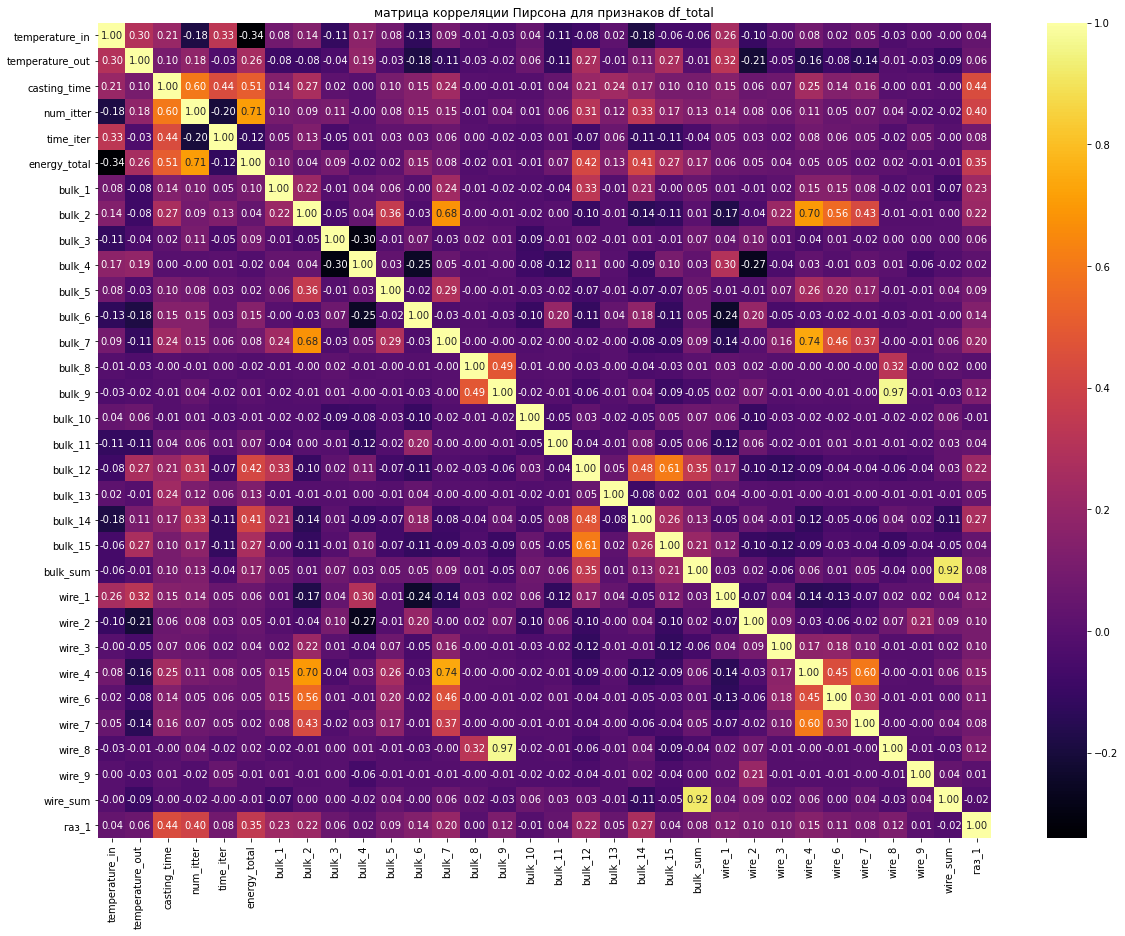

In [85]:
corr_make (df_total.drop('key',axis=1),'df_total',width=20, height=15)

Между признаками bulk_sum и wire_sum, а также между wire_8 и bulk_9 обнаружена сильная мультиколлинеарность. Значения коэффициента корреляции Пирсона составляют 0.92 и 0.97 соответственно.
Удалим признаки **wire_sum и wire_8** 

In [86]:
df_total.drop(['wire_sum', 'wire_8'], axis=1, inplace=True)

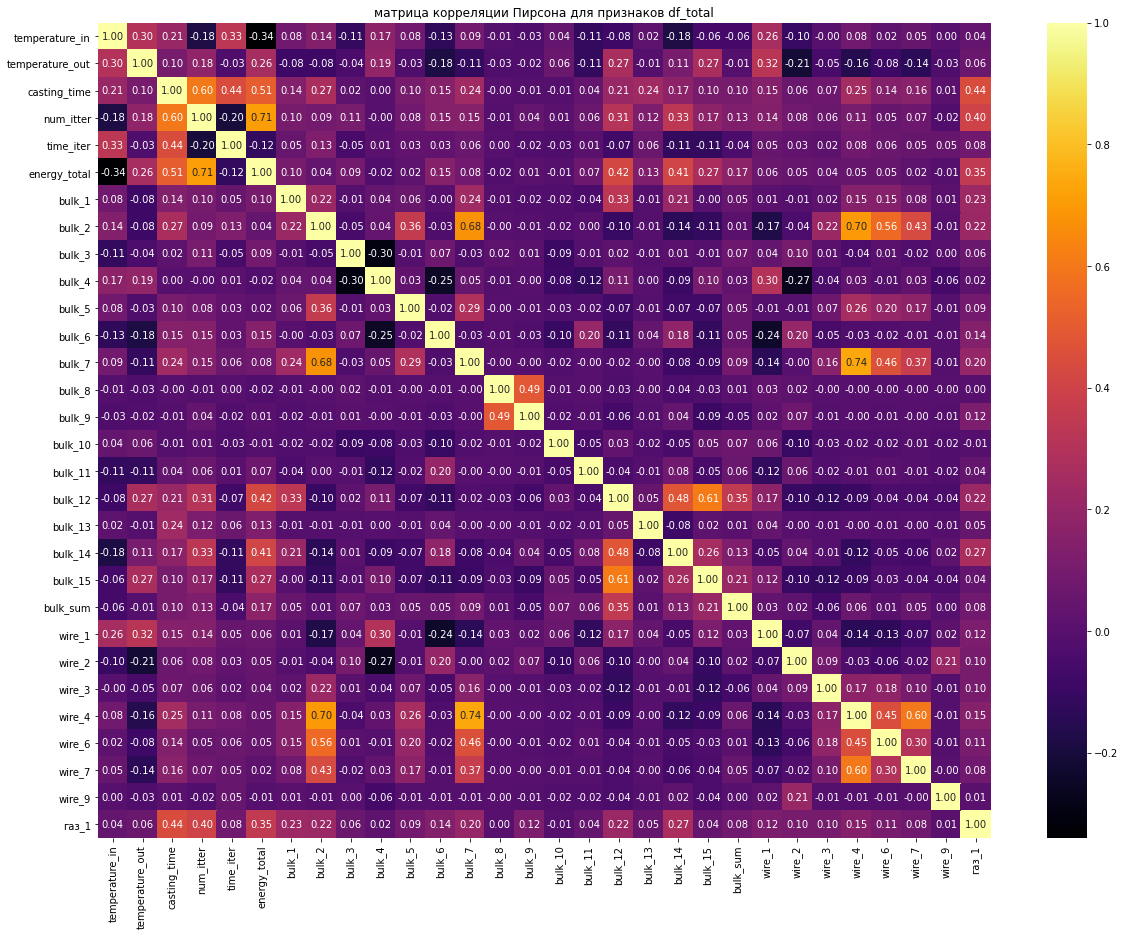

In [87]:
corr_make (df_total.drop('key',axis=1),'df_total',width=20, height=15)

Целевой признак `temperature_out` слабо  положительно коррелирует  в  порядке убывания:
- wire_1 0.32
- temperature_in 0.30
- bulk_15, bulk_12 - 0.27
- energy_total - 0.26
- wire_2 - 0.21
слабо отрицательно коррелирует:
- wire_2  - 0.21
- wire_4  - 0.16
- wire_7 - 0.14


Построим диаграммы рассеяния  с целевым признаком.

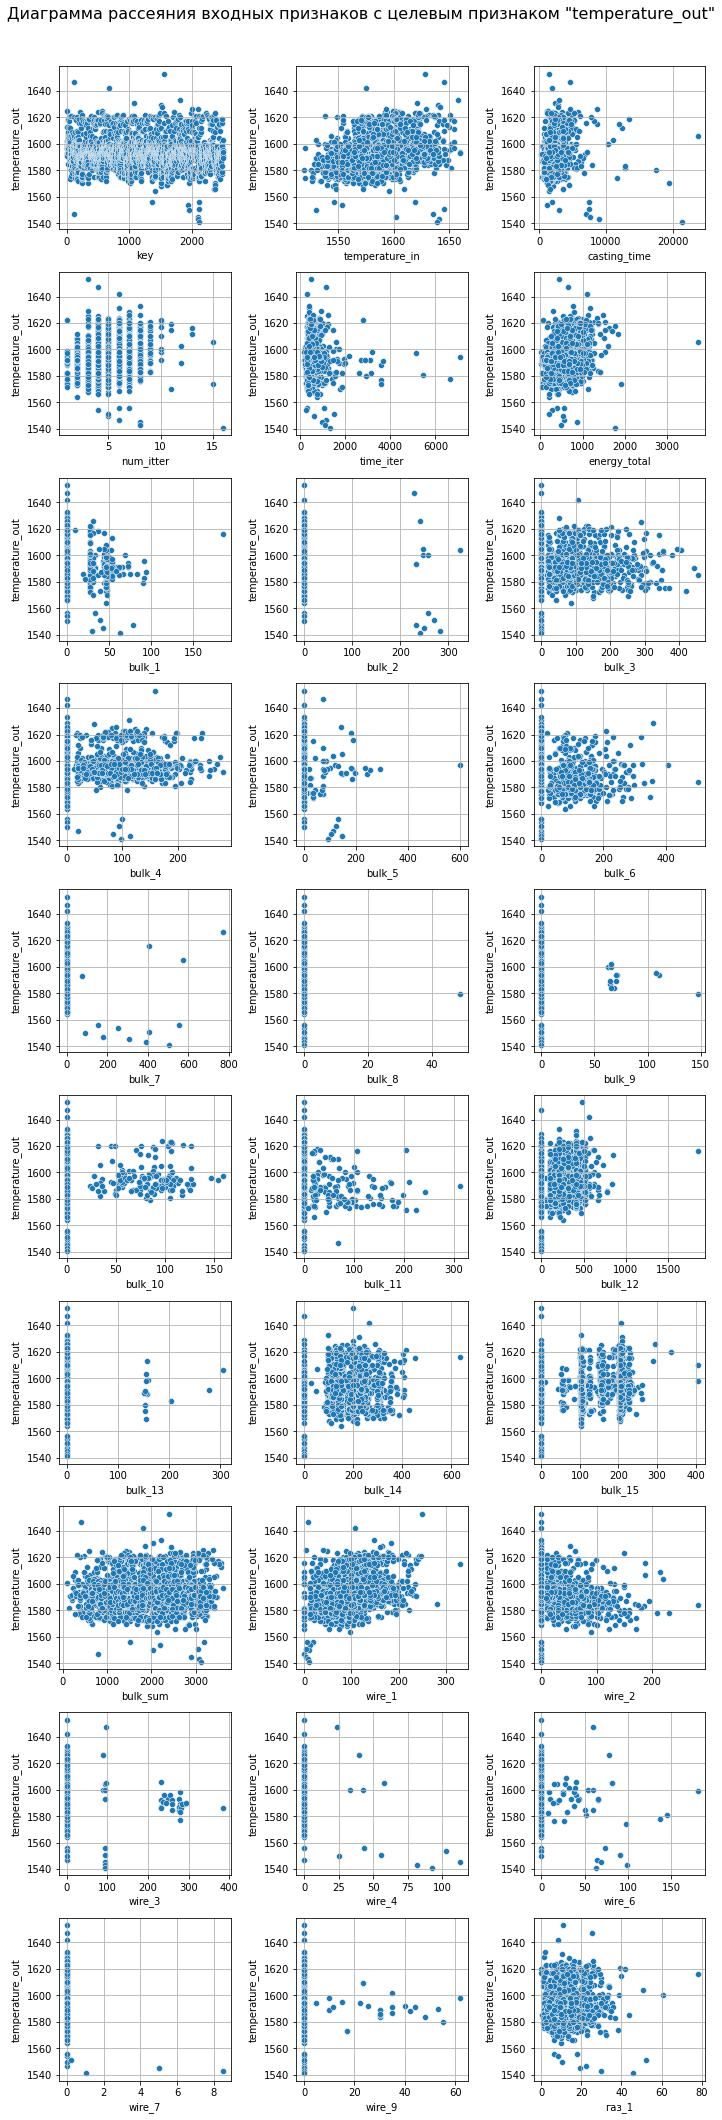

In [88]:
fig, axes =plt.subplots(nrows=10, ncols=3,figsize=(10,30))
fig.suptitle('Диаграмма рассеяния входных признаков с целевым признаком "temperature_out"', fontsize=16)
for i, column in enumerate (df_total.drop('temperature_out',axis=1).columns):
        sns.scatterplot(data=df_total,x=column, y='temperature_out',ax=axes[i//3,i%3])
        # axes[i//3,i%3].set_title(column)
        # axes[i//3, i%3].legend(fontsize='small')
        axes[i//3, i%3].grid(True)
        
plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig('scatter_plots.png', dpi=300)
plt.show()       

Быобнаружили следующие закономерности:
Наблюдается положительная линейная связь между признаком temperature_in и выходной температурой (temperature_out): чем выше входная температура, тем выше выходная температура.
Признак energy_total также показывает положительную связь с temperature_out, но она менее выражена.

Кроме того, были выявлены признаки, которые следует исключить из наблюдений:
Исключим  из наблюдений следующие признаки:
- bulk_2, bulk_8, wire_7 Эти признаки имеют узкое распределение значений,сконцентрированных нуля, bulk_2 имеет кластер  из небольшого количества наблюдений  имеещих широкой спектр  значений целевого признака.
- 'key' по  сути я вляется  идентификатором a не признаком.

In [89]:
df_total_one= df_total.drop(['key','bulk_2','bulk_8','wire_7'],axis=1)

In [90]:
df_total_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature_in   2325 non-null   float64
 1   temperature_out  2325 non-null   float64
 2   casting_time     2325 non-null   float64
 3   num_itter        2325 non-null   int64  
 4   time_iter        2325 non-null   float64
 5   energy_total     2325 non-null   int64  
 6   bulk_1           2325 non-null   float64
 7   bulk_3           2325 non-null   float64
 8   bulk_4           2325 non-null   float64
 9   bulk_5           2325 non-null   float64
 10  bulk_6           2325 non-null   float64
 11  bulk_7           2325 non-null   float64
 12  bulk_9           2325 non-null   float64
 13  bulk_10          2325 non-null   float64
 14  bulk_11          2325 non-null   float64
 15  bulk_12          2325 non-null   float64
 16  bulk_13          2325 non-null   float64
 17  bulk_14       

На этом этапе был подготовлен итоговый датафрейм df_total,  включающий 2325 наблюдений, пречислим столбцы с признаками:
- temperature_in  -  входная температура;
- temperature_out  - целевой признак, температура на выходе;
- casting_time  - время выплавки;
- num_itter - количество итераций;
- time_iter - среднее время итерации;
- energy_total - cуммарная энергия  нагрева;
- bulk  - набор признаков  сыпучих реагентов;
- wire  - набор признаков проволочных компонентов;
- газ_1 - сведения о продувке газом.

Датафрейм готов для дальнейшей обработки и подготовки данных для обучения модели.

##  Подготовка данных

In [91]:
df_total_one.head()

temperature_in  temperature_out  casting_time  num_itter  time_iter  \
0          1571.0           1613.0        1714.0          5     342.80   
1          1581.0           1602.0        1265.0          4     316.25   
2          1596.0           1599.0        1753.0          5     350.60   
3          1601.0           1625.0        1220.0          4     305.00   
4          1576.0           1602.0        1536.0          4     384.00   

   energy_total  bulk_1  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_9  \
0           629     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1           395     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2           582     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3           544     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4           412     0.0     0.0    78.0     0.0     0.0     0.0     0.0   

   bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  bulk_sum     wire_1  \
0      0.0      0.0    206.0      0.0    150.0    154.0     554.0  60.059998   
1      0.0      0.0    206.0      0.0    149.0    154.0     584.0  96.052315   
2      0.0      0.0    205.0      0.0    152.0    153.0     547.0  91.160157   
3      0.0      0.0    207.0      0.0    153.0    154.0     599.0  89.063515   
4      0.0      0.0    203.0      0.0    151.0    152.0     589.0  89.238236   

    wire_2  wire_3  wire_4  wire_6  wire_9      газ_1  
0  0.00000     0.0     0.0     0.0     0.0  29.749986  
1  0.00000     0.0     0.0     0.0     0.0  12.555561  
2  0.00000     0.0     0.0     0.0     0.0  28.554793  
3  0.00000     0.0     0.0     0.0     0.0  18.841219  
4  9.11456     0.0     0.0     0.0     0.0   5.413692

Разделим датасет на целевой и входные признаки.
Сохраним целевой признак в переменную **y**, входные признаки в переменную **X**.

Разделим данные на тренировочную и тестовую выборки и валидационную выборки:
- 75% для обучения,
- 25% для тестирования.
  
RANDOM_STATE = 220724 определена  в импортах.

In [92]:

y = df_total_one['temperature_out']
X = df_total_one.drop('temperature_out', axis=1)
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

Для обучения воспользуемся моделями:

1.  ElasticNet(). Эта модель с регуляризацией и и возможностью комбинирования вида регуляризации 'lasso', 'ridge', **model_linreg**.
2.  LGBMRegressor() из библиотеки LightGBM, **model_lgbmr**.
В основе модели LGBMRegressor лежат деревья решений. Это реализация градиентного бустинга с использованием алгоритма LightGBM, специально предназначенная для задач регрессии.
3.  SVR() -модель опорных векторов  для задач регресии , **model_svr**.


В  нашем наборе  нет категориальных признаков, поэтому  кодирование не требуется. Числовые признаки отмасштабируем с помощью  standardScaler().
Подготовку и обучение выполним в пайплайне. Для подбора гиперпараметров воспользуемся OptunaSearchCV().

Оценивать модель будем с помощью  метрики **MAE ((Mean Absolute Error)**.

Целевой показатель:  **MAE<6.8**

Обучение  с подбором гипрепараметров реализовано в функции **pipe_oscv**,а вывод результатов -
в функции **oscv_result**.


In [93]:
model_linreg = ElasticNet(random_state=RANDOM_STATE)
model_lgbmr = LGBMRegressor(boosting_type='gbdt',random_state=RANDOM_STATE,verbosity=-1)
model_svr =SVR()

Функция **pipe_oscv** реализует обучение  и подбор гиперпараметров для моделей  используя  модуль OptunaSearchCV().
Параметры:
- model - инициализируемая модель;
- param  - словарь  распределений гиперпараметров  для  обучаемой модели (модуль distributions);
-  n_traials=50 количество итераций;
-  X_train=X_train, y_train=y_train - признаки для обучения.

In [94]:
def pipe_oscv (model, param, n_traials=500, X_train=X_train, y_train=y_train):
    
    pipe = Pipeline ([
        ('scaler', StandardScaler()),
        ('model',model )
         ])
    oscv = OptunaSearchCV(
        pipe,
        param,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        cv=5,
        n_trials=500,
        random_state=RANDOM_STATE,
        verbose=False
    )

    oscv.fit(X_train, y_train)
    return oscv


Функция **oscv_result**  выводит  параметры лучшей модели и метрику MAE, полученную  с помощью кросс-валидации,  для лучшей модели

In [95]:
def oscv_result (oscv, key=1):
    print(f'параметры лучшей модели :\n')
    for param, value in oscv.best_params_.items():
        print(f"{param}: {value}")
    if key== 1:
        print ('\n','Метрика MAE лучшей модели  полученная с помощью кросс-валидации:',
            abs( oscv.best_score_),'\n')    

In [96]:
def time_oscv():
    print('Время обучения и подбора гиперпараметров:\n')
    print(time_optuna.stdout)

Функция **plot_features** отрисовывает график важности признаков:
- feature - названия признаков,
- value - значения  признаков.

In [97]:
def plot_features (value,feature):
    df= pd.DataFrame({
    'feature': feature,
    'value': value
     }).sort_values(by='value', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='value', y='feature', data=df, palette='viridis')


    plt.title('График важности признаков.', fontsize=16, pad=20)
    plt.xlabel('Значение признака.', fontsize=10)
    plt.ylabel('Признак.', fontsize=10)
    plt.grid(True)

    plt.show()

Словари параметров для моделей:
- param_model_linreg - ElasticNet()
- param_model_lgb   - LGBMRegressor()
- param_model_svr -SVR() 

<font color='blue'><b>Комментарий ментора</b></font><br>
<font color='green'> ✔️ Отличное решение с функциями </font>

In [98]:
param_model_linreg = { 
        
         
         'model__l1_ratio': distributions.FloatDistribution(0, 1,step= 0.005),
         'model__alpha': distributions.FloatDistribution(0.01, 100, step = 0.005)
}       

In [99]:
param_model_lgb = { 
        'model__learning_rate': distributions.FloatDistribution(0.005, 0.05,step=0.001), # (default=0.1)
        'model__n_estimators':distributions.IntDistribution(100,1000,step=10), #(default=100)
        'model__num_leaves': distributions.IntDistribution(10,200), # (default=31)
        'model__reg_alpha' : distributions.FloatDistribution(0.0, 5.0, step=0.1),
        'model__reg_lambda': distributions.FloatDistribution(0.0, 5.0, step=0.1)
}

In [100]:
param_model_svr = { 
        'model__C': distributions.FloatDistribution(1e-3, 1e3, log=True), # (default=0.1)
        'model__degree': distributions.IntDistribution(1,5,1), # (default=31)
        'model__epsilon' : distributions.FloatDistribution(0.01, 1.0, step=0.01),
        'model__gamma': distributions.FloatDistribution(1e-4, 1e1, log=True),
        'model__kernel': distributions.CategoricalDistribution(['poly', 'rbf', 'sigmoid']) 
}

## Обучение моделей машинного обучения

#### Обучение, настройка и тестирование ElasticNet().

In [101]:
%%capture time_optuna
%%time
oscv_linreg = pipe_oscv(model_linreg, param_model_linreg)

In [102]:
time_oscv()

Время обучения и подбора гиперпараметров:

CPU times: user 52.7 s, sys: 7.02 s, total: 59.7 s
Wall time: 59.8 s



In [103]:
oscv_result(oscv_linreg)

параметры лучшей модели :

model__l1_ratio: 0.975
model__alpha: 0.08499999999999999

 Метрика MAE лучшей модели  полученная с помощью кросс-валидации: 6.573581735900075 



Модель ElasticNet достигла значения MAE, лучшего чем установленный порог 6.8 и потенциальногможет быть использована для прогнозирования температуры. Оценим важность признаков котырые модель использовала для прогнозирования.Напомним, что ElasticNet является линейной моделью, и признаки, имеющие наибольший вес, линейно связаны с целевым признаком.Это означает, что признаки с наиболее значимыми коэффициентами в модели оказывают наибольшее влияние на предсказания температуры. Проанализируем  эти признаки и выясним ключевые факторы, влияющие на температурные изменения.
Извлечем регрессионные коэффициенты и построим горизонтальную диаграмму признаков.

In [104]:
linear_estimator = oscv_linreg.best_estimator_
value = abs(linear_estimator.named_steps['model'].coef_)
feature = linear_estimator.named_steps['scaler'].get_feature_names_out()


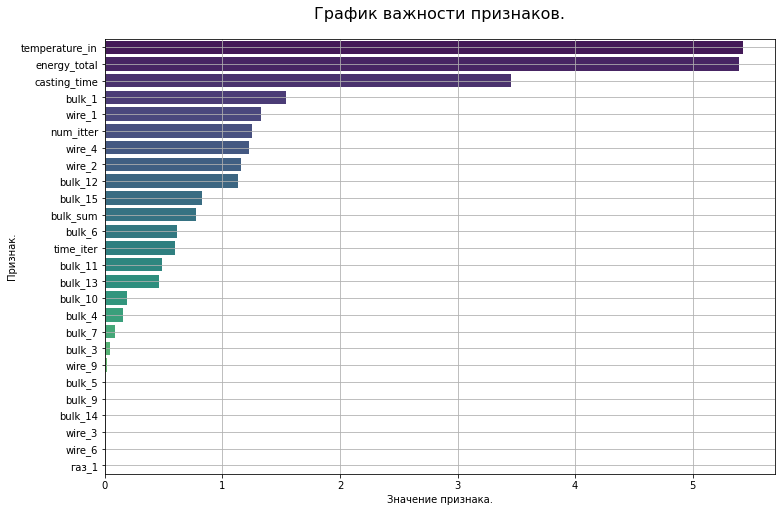

In [105]:
plot_features (value,feature)

Наиболее весомый вклад в прогнозирование температуры  внесли три признака:
- начальная температура  стали;
- затраченная энергия на нагрев стали, вычисленная по формуле
  $\sum_{i=1}^{20} P_i \cdot t_i$, где P - активная  мощность на i итерации ,
  t - интервал  времени в сек. на i  итерации, n - число итераций.
- общее время выплавки.
  
Менее весомый вклад внесли признаки определеящие состав реагентов и легирующих добавок, пречислем основные из них: bulk_1, wire_1, wire_2, wire_4, bulk_12, bulk_15.
Также модель выявила линеную зависимость  с агрегированным признаком bulk_sum  и
средним временем итерации  time_iter.

Между признаками газ-1 bulk_5, bulk_9, wire_3  и  темпреатурой  линеной зависимости модель не выявила линеной зависимости.

#### Обучение, настройка LGBMRegressor()

In [ ]:
%%capture time_optuna
%%time
oscv_lgbmr= pipe_oscv(model_lgbmr, param_model_lgb)

In [ ]:
time_oscv()

In [ ]:
oscv_result(oscv_lgbmr)

Модель LGBMRegressor() достигла значения MAE, лучшего чем установленный порог 6.8 и потенциальногможет быть использована для прогнозирования температуры. Оценим важность признаков котырые модель использовала для прогнозирования. Напомним, что LGBMRegressor является нелинейной моделью, основанной на градиентном бустинге деревьев решений. Проанализируем эти признаки, чтобы выявить ключевые факторы, влияющие на изменения температуры. Извлечем значения важности признаков (feature importance) и построим горизонтальную диаграмму для наглядного представления вклада каждого признака.

In [ ]:
lgbmr_estimator = oscv_lgbmr.best_estimator_
value = abs(lgbmr_estimator.named_steps['model'].feature_importances_)
feature = lgbmr_estimator.named_steps['scaler'].get_feature_names_out()


In [ ]:
plot_features (value,feature)

Наиболее весомый вклад в прогнозирование температуры  внесли те же два признака,
что и в модели  ElasticNet():
- начальная температура  стали;
- затраченная энергия на нагрев стали, вычисленная по формуле
  $\sum_{i=1}^{20} P_i \cdot t_i$, где P - активная  мощность на i итерации ,
  t - интервал  времени в сек. на i  итерации, n - число итераций.
Третий  по важности  признак  bulk_sum в модели  ElasticNet()  находился на 10 месте.

Перечислим 4 признака  которые также внесли существенный вклад в прогнозирование:
- bulk_14;
- wire_1;
- газ_1, отметим,что ElasticNet() не установила связи этого признака с температурой;
- time_iter
  
  


Между признаками  bulk_5, bulk_9,bulk_13,bulk_7 wire_4, wire_9, wire_6  и  темпреатурой  модель зависимости не  выявила.


Каждая модель выделяет свои важные признаки из одного и того же датасета. Поэтому  стоит взвешенно подходить к их удалению. Это позволит каждой модели использовать всю доступную информацию для наилучшего прогнозирования.

#### Обучение, настройка SVR

In [ ]:
%%capture time_optuna
%%time
oscv_svr= pipe_oscv(model_svr, param_model_svr)

In [ ]:
time_oscv()

In [ ]:
oscv_result(oscv_svr)

##  Выбор лучшей модели

Подведем итоги:
Лучшая модель по результатам метрики полученной на коросс-валидации  (oscv_svr)

Проверим качество модели на тестовых данных.

In [ ]:

pred = oscv_svr.predict(X_test)
mae_oscv =  mean_absolute_error(y_test,pred)
print('\n',f'Метрика MAE для лучшей модели на тестовой выборке: { mae_oscv:.5F}','\n')

oscv_result(oscv_svr, key=0)

Оценка точности dummy модели с использованием метрики MAE.

In [ ]:
# Подготовим данные  в шаге `preprocessor`.
X_test_dummy = oscv_svr.best_estimator_.named_steps['scaler'].transform(X_test)
X_train_dummy = oscv_svr.best_estimator_.named_steps['scaler'].transform(X_train)
dummy_regr = DummyRegressor()
model_dummy = dummy_regr.fit(X_train_dummy, y_train)
y_pred_dummy= model_dummy.predict(X_test_dummy)
print(f'Метрика MAE на тестовой выборке: {mean_absolute_error(y_test, y_pred_dummy):.4f}')

На основании результатов проверки можно заключить, что предсказания, основанные на среднем значении (используя DummyRegressor), показали значительно худшую точность по сравнению с нашей моделью.

Подготовим данные для анализа важности признаков:
1. `best_model` - имя лучшей модели.
2. `X_test_prepare` - отмасштабированная  `X_test'.
3. `X_train_prepare` - отмасштабированная `X_train'.
4.  column_name - список названий столбцов.

In [ ]:
print(oscv_svr.best_estimator_)

In [ ]:
best_model = oscv_svr.best_estimator_.named_steps['model']


In [ ]:
X_test_prepare = oscv_svr.best_estimator_.named_steps['scaler'].transform(X_test)
X_train_prepare = oscv_svr.best_estimator_.named_steps['scaler'].transform(X_train)
column_name = oscv_svr.best_estimator_.named_steps['scaler'].get_feature_names_out()

Для корректной работы метода SHAP семплируем X-train, X_test.( С размером выборки больше 100 метод выдает ошибку)

In [ ]:
shap.initjs()
X_train_prepare_sample = shap.sample(X_train_prepare, 100)
X_test_prepare_sample = shap.sample(X_test_prepare, 100)

In [ ]:
explaner = shap.KernelExplainer(best_model.predict, X_train_prepare_sample)

!!!Следующая  ячейка потребовала 100мин  для выполнения. Полученные результаты были сохранены в облаке.!!!
!!! Проект может быть продолжен как с выполнением этой ячейки, так и без, используя данные из облака.!!!

In [ ]:
shap_values = explaner(X_test_prepare_sample)

In [ ]:
# Код был выполнен при первоначальном запуске
# joblib.dump(shap_values, 'shap_values.pkl') 

In [ ]:
try:
    shap_values=shap_values
except:
    url="https://drive.google.com/uc?export=download&id=1yk3zmX8x_XI3F8MdxcKCSNg9Rk66h3Mg"
# Скачиваем файл
    response = requests.get(url)
    with open('shap_values.pkl', 'wb') as f:
          f.write(response.content)

# Загружаем объект
    shap_values_loaded = joblib.load('shap_values.pkl')

In [ ]:
# Создание summary plot
shap.summary_plot(shap_values, X_test_prepare_sample, plot_type='bar', feature_names=column_name, show=False)

# Получение текущей фигуры и изменение ее размера
plt.gcf().set_size_inches(8, 6)
plt.grid(True)
plt.tight_layout()
plt.show()


Наиболее весомый вклад в прогнозирование температуры  внесли те же  три признака, что  и для модели ElasticNet():
- начальная температура  стали;
- затраченная энергия на нагрев стали, вычисленная по формуле
  $\sum_{i=1}^{20} P_i \cdot t_i$, где P - активная  мощность на i итерации ,
  t - интервал  времени в сек. на i  итерации, n - число итераций.
- общее время выплавки.
  
Наименьший вклад внесли признаки определеящие состав реагентов и легирующих добавок, пречислем основные из них: bulk_3, wire_4, bulk_11,  bulk_10,  bulk_4, газ_1





In [ ]:
# shap_values.feature_names = column_name
shap.plots.beeswarm(shap_values, max_display=10) 


## Общий вывод  и рекомендации заказчику

В  рамках проекта были обучены три модели для решения задачи регрессии:
- ElasticNet() -модель линеной регресии  с возможностью балансировки lasso b ridgе регуляризаци.
- LGBMRegressor()-  В основе модели LGBMRegressor лежат деревья решений. Это реализация градиентного бустинга с использованием алгоритма LightGBM, специально предназначенная для задач регрессии.
- SVR() - модель  основанна на принципе опорных векторов, применяемому для решения задач регрессии.
Все  обученные модели достигли качества  лучшего чем установленный порог 6.8
- ElasticNet (oscv_linreg)  - MAE - 6.57
- LGBMRegressor (oscv_lgbmr) - MAE - 6.391
- SVR (oscv_svr) - MAE - 6.378
По итогам была выбрана модель  с наилучшим качеством  **SVR (oscv_svr)**
параметры лучшей модели :

C: 231.8811452025161
degree: 1
epsilon: 0.03
gamma: 0.0018419975903132464
kernel: rbf

Ядро 'rbf' позволяет моделям эффективно работать с нелинейными зависимостями в данных.

Модель была проверена на тестовых данных  и показал результат по метрике  
**MAE= 6.06426**, напомним целевое значение MAE < 6.8

Используемая для сравнения dummy модель  показала значительно худшую точность по сравнению с нашей моделью MAE = 8.2784

Наиболее весомый вклад в прогнозирование температуры внесли три признака:
- начальная температура стали;
- затраченная энергия на нагрев стали, вычисленная по формуле 
, где P - активная мощность на i итерации , t - интервал времени в сек. на i итерации, n - - число итераций;
- общее время выплавки.

Mодель SVR способна предсказывать температуру на выходе значительно лучше установленного порога MAE.
Мы надеемся, что внедрение и использование данной модели поможет оптимизировать производственные процессы и достичь более высоких показателей эффективности и качества продукции.
